<a href="https://colab.research.google.com/github/CaritoRamos/Predictive-Classification-Model-for-UNMSM-Admissions/blob/main/Web_Scraping_Predictive_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. WEB SCRAPING**

In [ ]:
#Instalacion del paquete de Selenium
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 12.1 MB/s eta 0:00:00


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support import expected_conditions as EC
from google.colab import files
import time
import json
import csv
import pandas as pd
import numpy as np

In [ ]:
!apt-get update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,944 kB]
Get:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4,387 kB]
Get:13 http://security.ubuntu.co

In [ ]:
!apt-get install chromium-driver

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'chromium-chromedriver' instead of 'chromium-driver'
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 libudev1 snapd squashfs-tools
  systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 snapd
  squashfs-tools systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 8 newly installed, 0 to remove and 99 not upgraded.
Need to get 30.3 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.co

In [ ]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

In [ ]:
#1. Iniciando el WebDriver
driver = web_driver()

In [ ]:
#2. Creando una función para extraer datos de una página de resultados
def extraer_datos_pagina():
    WebDriverWait(driver, 10).until(   #Esto espera a que la tabla de resultados esté cargada
        EC.presence_of_element_located((By.ID, "tablaPostulantes"))
    )

    #Para extraer los datos de la tabla:
    tabla = driver.find_element(By.ID, "tablaPostulantes")
    filas = tabla.find_elements(By.TAG_NAME, "tr")
    datos = []
    for fila in filas[1:]:  #Esto Ignora la fila de encabezados y comienza desde la siguiente fila
        columnas = fila.find_elements(By.TAG_NAME, "td")
        if columnas:
            datos.append([columna.text for columna in columnas])
    return datos

In [ ]:
#3. Creando una función para manejar la paginación
def manejar_paginacion():
    datos_carrera = []
    pagina_actual = 1  #Aquí iniciamos un contador para saber en qué página estamos
    while True:
        print(f"\nExtrayendo datos de la página {pagina_actual}...")

        #Para extraer datos de la página actual:
        datos_pagina = extraer_datos_pagina()
        print(f"Datos extraídos de la página {pagina_actual}: {len(datos_pagina)} filas")

        #Guardando los datos en la lista "datos_carrera":
        datos_carrera.extend(datos_pagina)
        print(f"Total de datos acumulados: {len(datos_carrera)} filas")

        #Para verificar si el botón "Siguiente" está deshabilitado:
        try:
            boton_siguiente = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.ID, "tablaPostulantes_next"))
            )

            #Para desplazar la página hasta el botón "Siguiente":
            driver.execute_script("arguments[0].scrollIntoView();", boton_siguiente)
            time.sleep(1)  #Aqui esperará un momento para que la página termine de cargar y se estabilice

            #Si el botón está deshabilitado:
            if "disabled" in boton_siguiente.get_attribute("class"):
                print("El botón 'Siguiente' está deshabilitado. Fin de la paginación.")
                break  #Aquí sale del bucle
            else:
                #Para hacer clic en el botón "Siguiente" usando JavaScript:
                print("Haciendo clic en el botón 'Siguiente'...")
                driver.execute_script("arguments[0].click();", boton_siguiente)
                time.sleep(2)  #Aquí espera a que se cargue la siguiente página
                pagina_actual += 1  #Esto incrementa el contador de páginas
        except Exception as e:
            print(f"Error al manejar la paginación: {e}")
            break
    return datos_carrera

In [ ]:
#4. Creando una función para obtener los enlaces de las carreras
def obtener_enlaces_carreras(url):
    driver.get(url)
    #Espera a que la tabla de carreras esté cargada:
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.TAG_NAME, "tbody"))
    )

    #Para extraer los enlaces de las carreras:
    tabla_carreras = driver.find_element(By.TAG_NAME, "tbody")
    filas_carreras = tabla_carreras.find_elements(By.TAG_NAME, "tr")
    enlaces_carreras = []
    for fila in filas_carreras:
        enlace = fila.find_element(By.TAG_NAME, "a").get_attribute("href")
        enlaces_carreras.append(enlace)
    return enlaces_carreras

In [ ]:
#5. Ahora creamos la función principal main:
def main():
    #Ingresamos la URL de la página principal
    #url = "https://admision.unmsm.edu.pe/Website20251/index.html"   #2025-1
    #url = "https://admision.unmsm.edu.pe/Website20252GeneralA/"     #2025-2 A
    url = "https://admision.unmsm.edu.pe/Website20252General/"       #2025-2 General

    #Para obtener el primer enlace de la modalidad de ingreso que sale al abrir la página:
    driver.get(url)
    enlace_modalidad = driver.find_element(By.LINK_TEXT, "EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁSICA ALTERNATIVA (EBA)").get_attribute("href")

    #Obteniendo los enlaces de las carreras:
    enlaces_carreras = obtener_enlaces_carreras(enlace_modalidad)
    if not enlaces_carreras:
        print("No se encontraron enlaces de carreras.")
        return

    #Se recopilan los datos de todas las carreras, enlace por enlace:
    todos_los_datos = []
    for enlace_carrera in enlaces_carreras:
        print(f"Procesando carrera: {enlace_carrera}")
        driver.get(enlace_carrera)
        datos_carrera = manejar_paginacion()
        todos_los_datos.extend(datos_carrera)

    #Se convierten los datos a un DataFrame:
    df = pd.DataFrame(todos_los_datos, columns=['CODIGO', 'APELLIDOS Y NOMBRES', 'ESCUELA PROFESIONAL', 'PUNTAJE', 'MERITO E.P', 'OBSERVACIÓN'])

    #Guardamos los datos en un archivo CSV:
    df.to_csv('resultados_unmsm_completo.csv', index=False)
    print("Datos extraídos y guardados en 'resultados_unmsm_completo.csv'")

    #Se cierra el navegador:
    driver.quit()

In [ ]:
#6. Ejecutando la función principal main:
if __name__ == "__main__":
    main()

Procesando carrera: https://admision.unmsm.edu.pe/Website20252General/A/022/0.html

Extrayendo datos de la página 1...
Datos extraídos de la página 1: 10 filas
Total de datos acumulados: 10 filas
Haciendo clic en el botón 'Siguiente'...

Extrayendo datos de la página 2...
Datos extraídos de la página 2: 10 filas
Total de datos acumulados: 20 filas
Haciendo clic en el botón 'Siguiente'...

Extrayendo datos de la página 3...
Datos extraídos de la página 3: 10 filas
Total de datos acumulados: 30 filas
Haciendo clic en el botón 'Siguiente'...

Extrayendo datos de la página 4...
Datos extraídos de la página 4: 10 filas
Total de datos acumulados: 40 filas
Haciendo clic en el botón 'Siguiente'...

Extrayendo datos de la página 5...
Datos extraídos de la página 5: 10 filas
Total de datos acumulados: 50 filas
Haciendo clic en el botón 'Siguiente'...

Extrayendo datos de la página 6...
Datos extraídos de la página 6: 10 filas
Total de datos acumulados: 60 filas
Haciendo clic en el botón 'Siguien

KeyboardInterrupt: 

In [ ]:
#7. Para descargar el documento csv:
from google.colab import files
files.download('resultados_unmsm_completo.csv')

FileNotFoundError: Cannot find file: resultados_unmsm_completo.csv

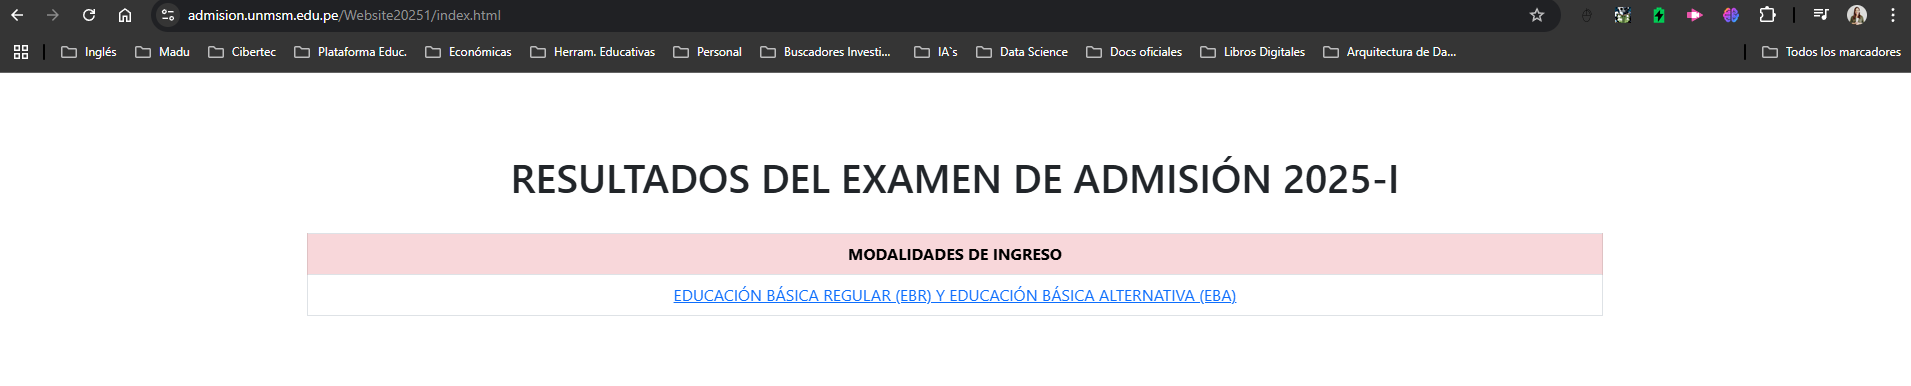

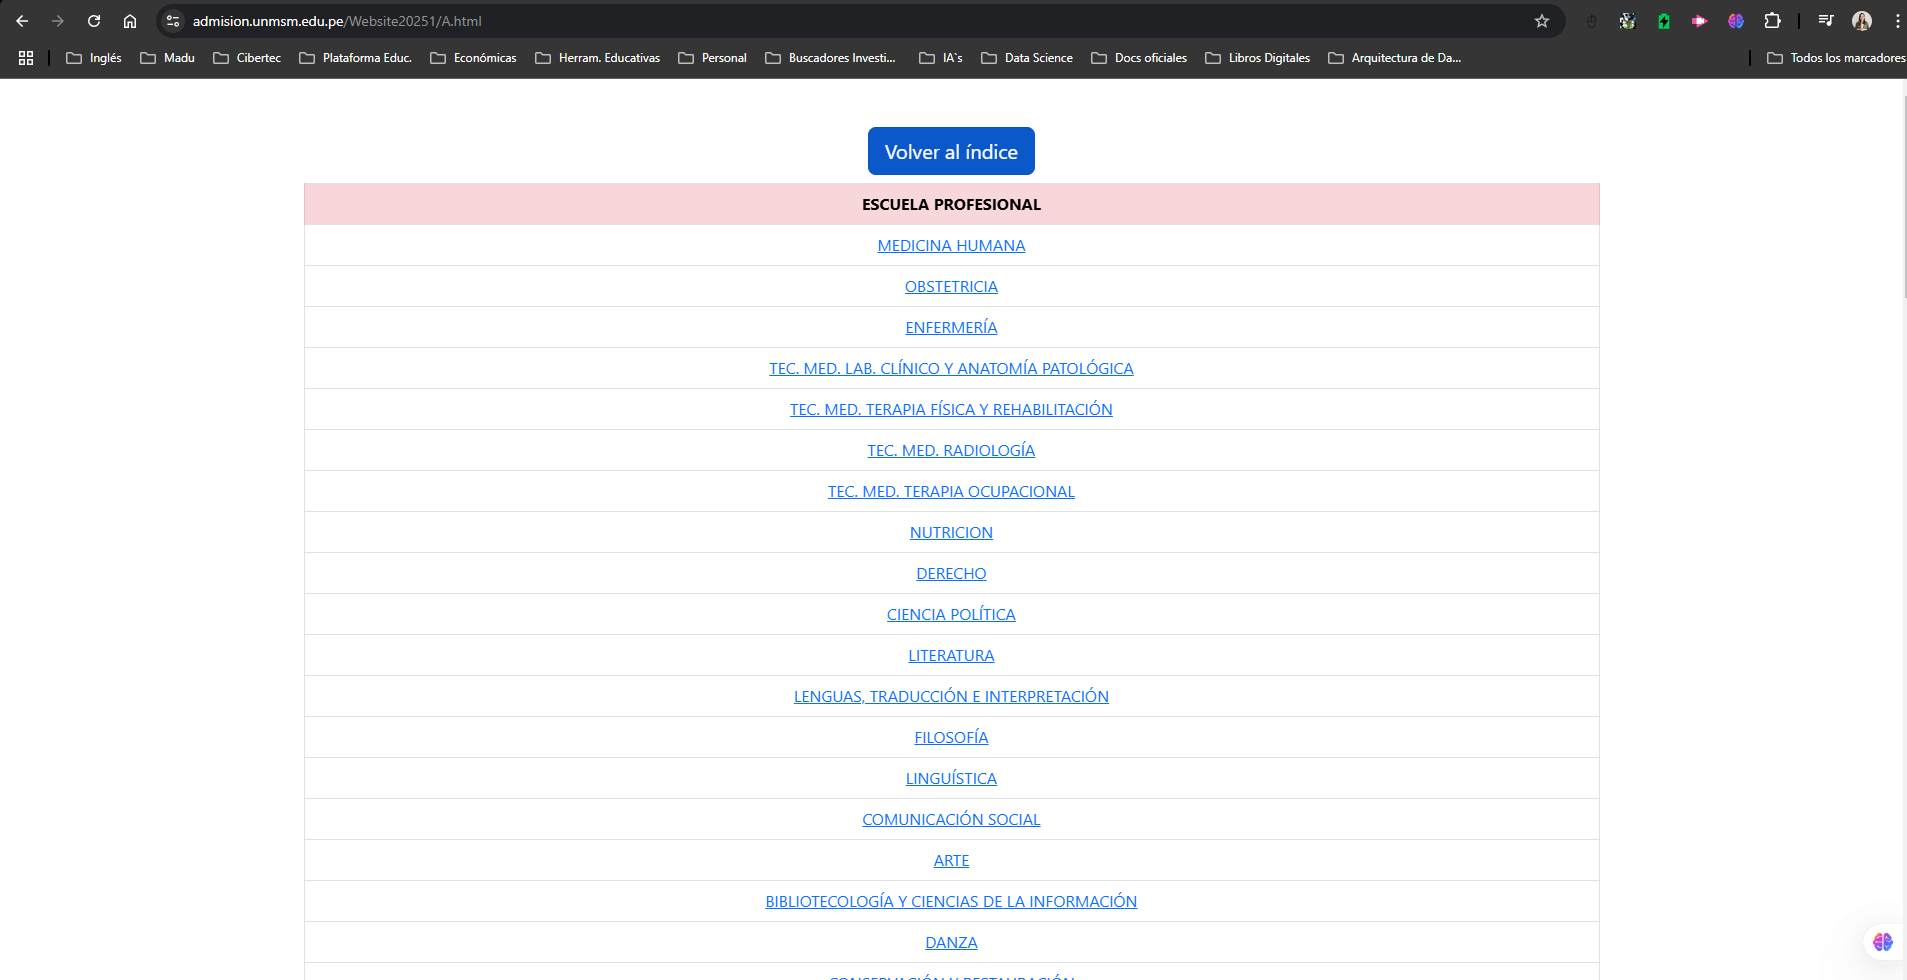

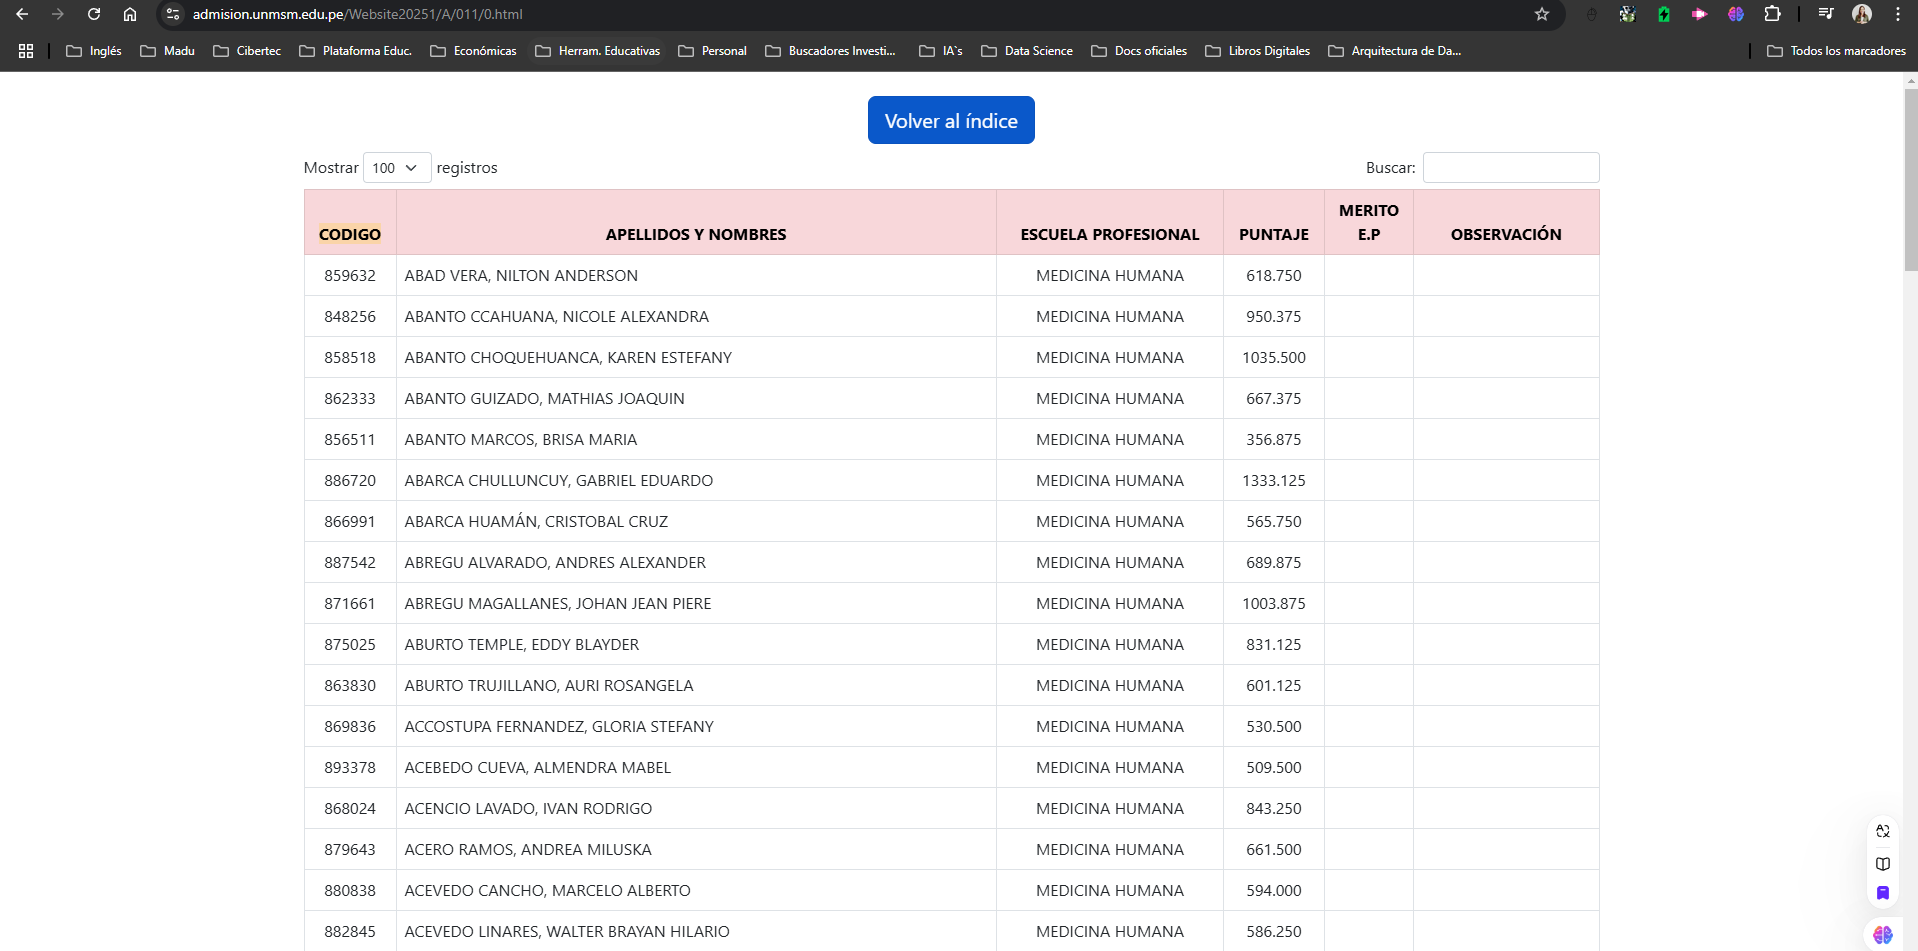